<a href="https://colab.research.google.com/github/aryankotru/MINERVA/blob/min_alpha/MINERVA_Preprocessing_Unit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pywt
import os
from scipy.stats import entropy
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.signal import butter, sosfilt, sosfreqz, lfilter, iirnotch, spectrogram

global variable declaration

In [5]:
epoch = 710
num_epochs = 12
blocks = 2
# Sample rate and desired cutoff frequencies (in Hz)*
fs = 250
lowcut = 1
highcut = 30
filter_order = 9
notch_quality_factor = 0.693
wavelet = 'sym9'

freq_bands = {"delta": [0.3, 4], "theta": [4, 8], "alpha": [8, 13], "beta": [13, 30], "gamma": [30, 50]}
chars = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "0", "*", "#"]
stim_freqs = {9.25: 0, 11.25 : 0, 13.25 : 0, 9.75 : 0.5 , 11.75 : 0.5 , 13.75 : 0.5, 10.25 : 1, 12.25 : 1, 14.25: 1, 10.75 : 1.5, 12.75 : 1.5, 14.75 : 1.5}

channel_names = ["POz", "PO3", "PO4", "PO5", "PO6", "Oz", "O1", "O2"]

T =  2.84
nsamples = T * fs
t = np.arange(0, epoch) / fs

input data

In [112]:
#Load EEG data from the csv file
df = pd.read_csv("S001.csv", header = None)
df = np.transpose(df)
df.columns = channel_names
df

,POz,PO3,PO4,PO5,PO6,Oz,O1,O2
0,-52325.520058,-18745.512888,-21403.269255,-15633.971431,-20347.417614,-9890.825146,-21657.900313,-18416.808153
1,-53157.228420,-18924.997385,-22218.034996,-15684.843998,-20429.269697,-9916.037912,-21772.430645,-18462.495116
2,-55446.940985,-18735.454603,-23016.528667,-15365.258775,-20164.356838,-9598.106718,-21580.205654,-18162.221799
3,-55945.653078,-18482.030540,-22753.001616,-15137.583920,-19940.481778,-9375.259839,-21344.081840,-17942.995902
4,-54100.159055,-18461.198715,-21738.858327,-15286.223011,-20024.747850,-9530.604454,-21378.190600,-18058.777932
...,...,...,...,...,...,...,...,...
170395,12259.662882,11984.289407,11000.365675,11004.657209,6387.859964,13515.428514,14307.306070,13128.832765
170396,12163.639794,11957.243798,10855.884007,10989.636838,6245.568767,13490.215748,14325.992127,13112.739510
170397,12169.183026,11944.637414,10865.539960,10982.797204,6247.759238,13501.033992,14342.487713,13133.794852
170398,12247.369423,11972.308872,10988.519251,10995.582401,6361.574314,13502.017468,14304.489750,13105.452842


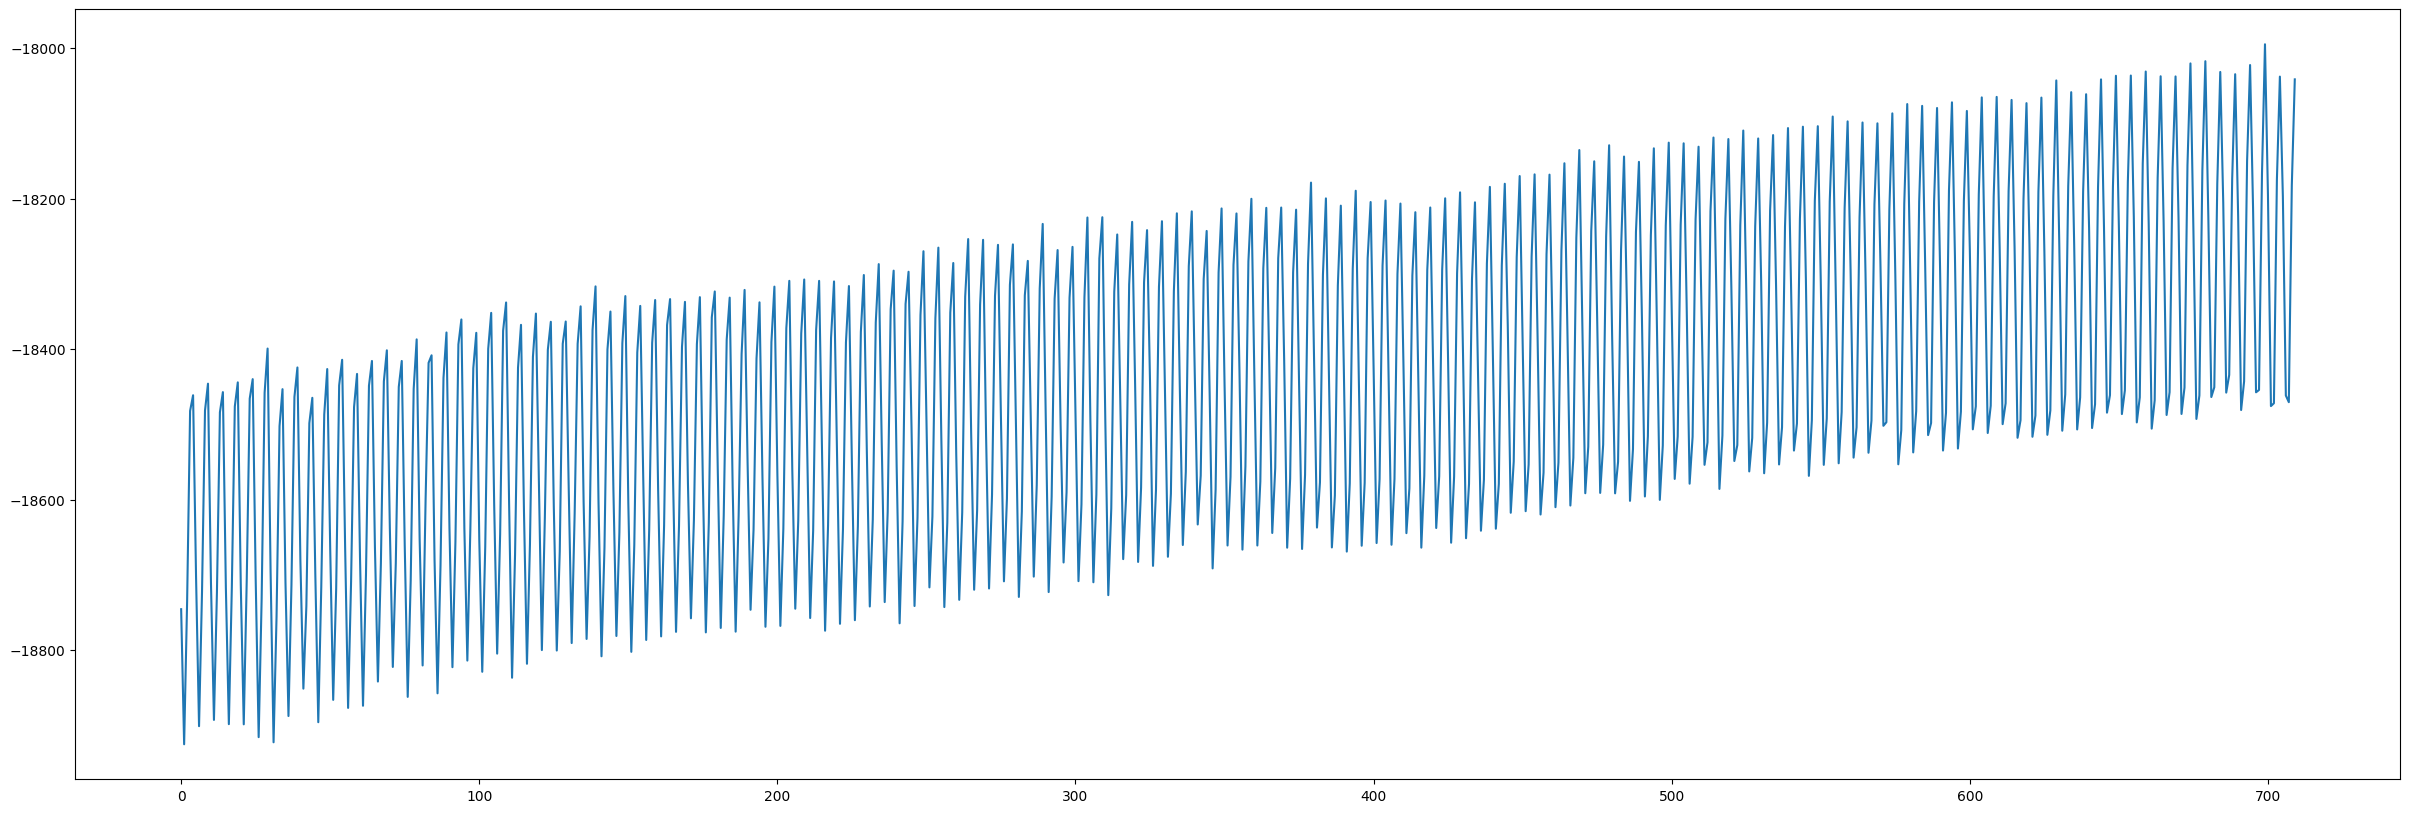

In [101]:
plt.figure(figsize = (30,10))
plt.plot(df.iloc[0*epoch:1*epoch, 1])

testing, validation and training data

In [ ]:
train, valid, test = np.split(df, [int(0.6*len((df))), int(0.8*len(df))])
num_rows, num_cols = df.shape
num_epochs = int((num_rows)/epoch)
#num_epochs

data filtering

In [36]:
def notch_filter(data, rate, freq, quality):

    x = scipy.signal.filtfilt(*scipy.signal.iirnotch(freq / (rate / 2), quality), data)
    #https://neuraldatascience.io/7-eeg/erp_filtering.html
    return x

def butter_bandpass(lowcut, highcut, fs, order=filter_order):
        nyq = 0.5 * fs #
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog=False, btype='band', output='sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=filter_order):
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        y = sosfilt(sos, data)
        return y

data normalization

In [37]:
def dataset_scaler(dataframe):
  scaler = MinMaxScaler() #normalizing data points, object of class StandardScaler
  minmax_scaled_data = scaler.fit_transform((dataframe))
  np.reshape(minmax_scaled_data, dataframe.shape)
  scaled_data = np.vstack((minmax_scaled_data))
  plt.figure()
  dfa = pd.DataFrame(minmax_scaled_data)
  #dfa.columns = cols #index for columns
  return dfa

In [ ]:
#train = dataset_scaler(train)
#df = dataset_scaler(df) #only transform training data

<Figure size 640x480 with 0 Axes>

In [38]:
def calculate_features(coeffs):
    mean_val = np.mean(coeffs)
    std_val = np.std(coeffs)
    skewness_val = scipy.stats.skew(coeffs)
    entropy_val = entropy(np.abs(coeffs))
    return mean_val, std_val, skewness_val, entropy_val
feature_names = ['mean', 'std', 'skewness', 'entropy']

In [ ]:

for n in range(7):
  data = df.iloc[:epoch, 0]
  coeffs = pywt.wavedec(data, wavelet)
  # Plot the detail coefficients
  for i, coeff in enumerate(coeffs[1:], 1):
    if(i ==1):
      continue
    else:
      plt.figure(figsize=(10, 8))
      plt.subplot(len(coeffs) - 1, 1, i)
      plt.plot(coeff)
      plt.title(f'Detail Coefficients Level {i}')
  plt.figure(figsize=(10, 8))
  plt.subplot(len(coeffs) -1, 1, 1)
  plt.plot(coeffs[0])
  plt.title(f'Approximation Coefficients Level {i} for Channel {n+1}')
  plt.tight_layout()
  plt.show()
#https://drive.google.com/file/d/1Axi2NdCyutM_eVkewdMsQgotnqzJAWNP/view
#ON HOLD FOR TIME BEING, FINISH FIRST PASS IMPLEMENTATION, THEM COME BACK, FIGURE THIS OUT AND FINE TUNE

wavelet transform & feature extraction

In [39]:
def feature_generator(df, channel_names, epoch_len):
  #feature_df = pd.DataFrame()
  channel_list = []
  channel_dict = {}
  num_epochs = int(len(df.index)/epoch_len)
  #print(num_epochs)

  for channel in range(len(channel_names)):
    channel_list = []

    for n in range(num_epochs):
      data = df.iloc[n*epoch_len:(n+1)*epoch_len, channel]
      coeffs = pywt.wavedec(data, wavelet)

      for i, coeff in enumerate(coeffs[2:], 1):
          #print(f'Detail Coefficients Level {i}')
          mean, std, sk, se = calculate_features(coeff) #calculate features for detail coefficients
          #feature = calculate_features(coeff)
          channel_list.append(mean)
          channel_list.append(std)
          channel_list.append(sk)
          channel_list.append(se)
      #https://www.freecodecamp.org/news/clean-coding-for-beginners/
      mean, std, sk, se = calculate_features(coeffs[0]) #calculate features for approximation coefficients
      channel_list.append(mean)
      channel_list.append(std)
      channel_list.append(sk)
      channel_list.append(se)
    #print(f"For channel {channel} length is: " + str(len(channel_list)))
    channel_dict[channel_names[channel]] = channel_list
    #print(channel_dict[channel_names[channel]])
    feature_df = pd.DataFrame.from_dict(channel_dict)

    #ADD DATASET LABELLER
  return feature_df

    #print(f'Approx. Coefficients Level {i} for Channel {channel} epoch {n}')

  #print(channel_list)
  #channel_dict = {key: val for val, key in enumerate(channel_dict.keys(), channel_list)}

#feature_generator(train, channel_names, 710)


dataset labeller

In [40]:
def dataset_labeller(dataframe, num_features_per_epoch, chars):
  num_samples = len(dataframe) // num_features_per_epoch  # 4800 / 20 = 240 samples
  num_labels = len(chars)  # 12 labels

  # Create a list of labels for each 20-row segment
  labels = []
  for i in range(num_samples):
      labels.extend([chars[i % num_labels]] * 20)
  # Add the labels to the DataFrame
  dataframe.insert(dataframe.shape[1], 'Label', labels, allow_duplicates = False) #df.shape[1] returns the number of columns
  return dataframe

main function

In [79]:
def preprocessing(dataframe, epoch_len):
   filtered_df = pd.DataFrame(columns=dataframe.columns)
   num_epochs = int(len(dataframe.index)/epoch_len)
   #print(num_epochs)

   for channel, i in enumerate(dataframe.columns):
      filtered_col_data = []
      for n in range(num_epochs):
          data = dataframe.iloc[n*epoch:(n+1)*epoch, channel]
          data = notch_filter(data, fs, 50, notch_quality_factor)
          data = butter_bandpass_filter(data, lowcut, highcut, fs, order=filter_order)
          filtered_col_data.extend(data)
      filtered_df[i] = filtered_col_data
   filtered_df = dataset_scaler(filtered_df) #scale dataset after filtering
   feature_df = feature_generator(filtered_df, channel_names, epoch_len) #extract and store features

   return dataset_labeller(feature_df, 20, chars)


da = preprocessing(df, 710)

<Figure size 640x480 with 0 Axes>

In [80]:
da.to_excel('MIN10.xlsx', sheet_name='sheet1', index=False, float_format = "%.8f")

In [ ]:
da

In [ ]:
def find_outliers(df):
    rows, cols = df.shape
    outliers = []

    # Iterate through each cell in the DataFrame
    for i in range(rows):
        for j in range(cols):
            current_value = df.iloc[i, j]
            is_outlier = True

            # Scan through neighbors within a range of 3 cells
            for x in range(max(0, i - 3), min(rows, i + 4)):
                for y in range(max(0, j - 3), min(cols, j + 4)):
                    if (x == i and y == j):  # Skip the current cell
                        continue
                    neighbor_value = df.iloc[x, y]
                    if 8 * current_value <=  1* neighbor_value or np.abs(8 * current_value) <= np.abs( 1* neighbor_value):
                        is_outlier = False
                        break
                if not is_outlier:
                    break

            # If the cell is an outlier, add its position and value to the list
            if is_outlier:
                outliers.append({'Position': (i, j), 'Value': current_value, 'Neighbour Values' : neighbor_value, 'Neighbour Position: ':(x,y)})

    return outliers

# Find outliers
outliers = find_outliers(da.iloc[:, 0:7])
print("\nOutliers:")
for outlier in outliers:
    print(outlier)


In [ ]:

def find_column_outliers(df, factor=5):
    # Ensure all data is numeric
    df = df.apply(pd.to_numeric, errors='coerce')
    rows, cols = df.shape
    outliers = []

    # Iterate through each cell in the DataFrame
    for i in range(rows):
        for j in range(cols):
            current_value = df.iloc[i, j]
            if pd.isna(current_value):  # Skip if the value is NaN
                continue
            is_outlier = True

            # Scan through neighbors within a range of 3 cells in the same column
            for x in range(max(0, i - 3), min(rows, i + 4)):
                if x == i:  # Skip the current cell itself
                    continue
                neighbor_value = df.iloc[x, j]
                if pd.isna(neighbor_value):  # Skip if neighbor is NaN
                    continue
                # Use a factor to check if the current value is significantly larger
                if current_value <= factor * neighbor_value:
                    is_outlier = False
                    break

            # If the cell is an outlier, add its position and value to the list
            if is_outlier:
                outliers.append({'Position': (i, j), 'Value': current_value, 'Neighbour Values' : neighbor_value, 'Neighbour Position: ':(x,j)})

    return outliers

# Find column-wise outliers
outliers = find_column_outliers(da.iloc[:, 0:7])
print("\nColumn-wise Outliers:")
for outlier in outliers:
    print(outlier)


In [ ]:
def dataset_output(dataframe, file_path):
  file_names = []
  file_path = "/content"
  for x in os.listdir(file_path):
    if x.endswith(".csv"):
      print(x)
      file_names.append(x)
      print(file_names)
      #print(os.path.basename(x))
  #dataframe.name = "%.xlsx"
  print(f"{dataframe.name}")
  #file_name = f'{dataframe.name}.xlsx'
  """dataset = da.to_excel('test2.xlsx', sheet_name='sheet1', index=False, float_format = "%.8f")
  return dataset
"""
dataset_output(da, "/content")


S001.csv
['S001.csv']


AttributeError: 'DataFrame' object has no attribute 'name'

In [ ]:
def main():
  return